In [1]:
import warnings
#スクリプト実行時に表示される警告メッセージを制御
warnings.filterwarnings("ignore") 

import os
#tokenizerライブラリ使用時の並列処理を抑制
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

def read_data(filename):
    #リストの作成
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            #０列目(ラベル)
            t = int(line[0])
            #ラベルの0→[1,0],1→[0,1]をlabelsに格納
            labels.append([1-t, t])
            #文章をsentencesに格納
            sentences.append(line[1:].strip())
    #labelsとsentencesを返す        
    return np.array(labels), sentences

#それぞれのデータにread_data()を行う
train_labels, train_sentences = read_data('mc_train_data_jp.txt')
dev_labels, dev_sentences = read_data('mc_dev_data_jp.txt')
test_labels, test_sentences = read_data('mc_test_data_jp.txt')

In [3]:
import spacy

#文のトークン化
def tokenise(sentence):
    #GiNZAモデルを用いる
    nlp = spacy.load("ja_ginza")
    doc = nlp(sentence)
    tokens = [token.text for token in doc]
    #トークンを返す
    return tokens

#それぞれのデータの翻訳文をトークン化する
train_tokenised = [tokenise(sentence) for sentence in train_sentences]
dev_tokenised = [tokenise(sentence) for sentence in dev_sentences]
test_tokenised = [tokenise(sentence) for sentence in test_sentences]

In [4]:
train_tokenised[0]

['熟練', 'し', 'た', '男', 'は', 'ソース', 'を', '準備', 'し', 'ます', '。']

In [5]:
from lambeq import BobcatParser
import japanize_matplotlib

#Bobcat Parserをパーサーとして用いる
parser = BobcatParser(verbose='suppress')

#リストの作成
raw_train_diagrams = []
raw_dev_diagrams = []
raw_test_diagrams = []

#トークン化した文をsentence2diagramで図式化
for i in range(len(train_tokenised)):
    raw_train_diagrams.append(parser.sentence2diagram(train_tokenised[i], tokenised=True))
for i in range(len(dev_tokenised)):
    raw_dev_diagrams.append(parser.sentence2diagram(dev_tokenised[i], tokenised=True))
for i in range(len(test_tokenised)):
    raw_test_diagrams.append(parser.sentence2diagram(test_tokenised[i], tokenised=True))

#Bobcat Parserの図を格納
train_diagrams = raw_train_diagrams
dev_diagrams = raw_dev_diagrams
test_diagrams = raw_test_diagrams

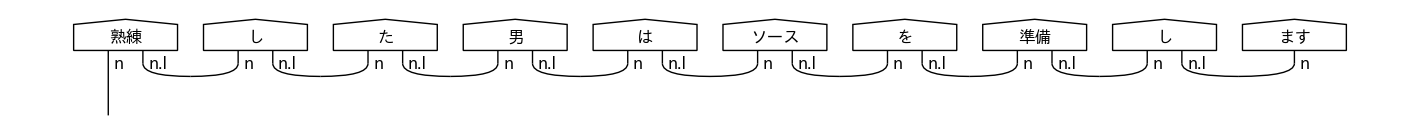

<bound method Diagram.draw of |Ty() @ Word(熟練, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Word(し, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(た, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(男, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(は, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(ソース, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(を, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(準備, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l 

In [6]:
raw_train_diagrams[0].draw(figsize=(14,3), fontsize=12)
train_diagrams[0].draw

In [7]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=2, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits = [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]


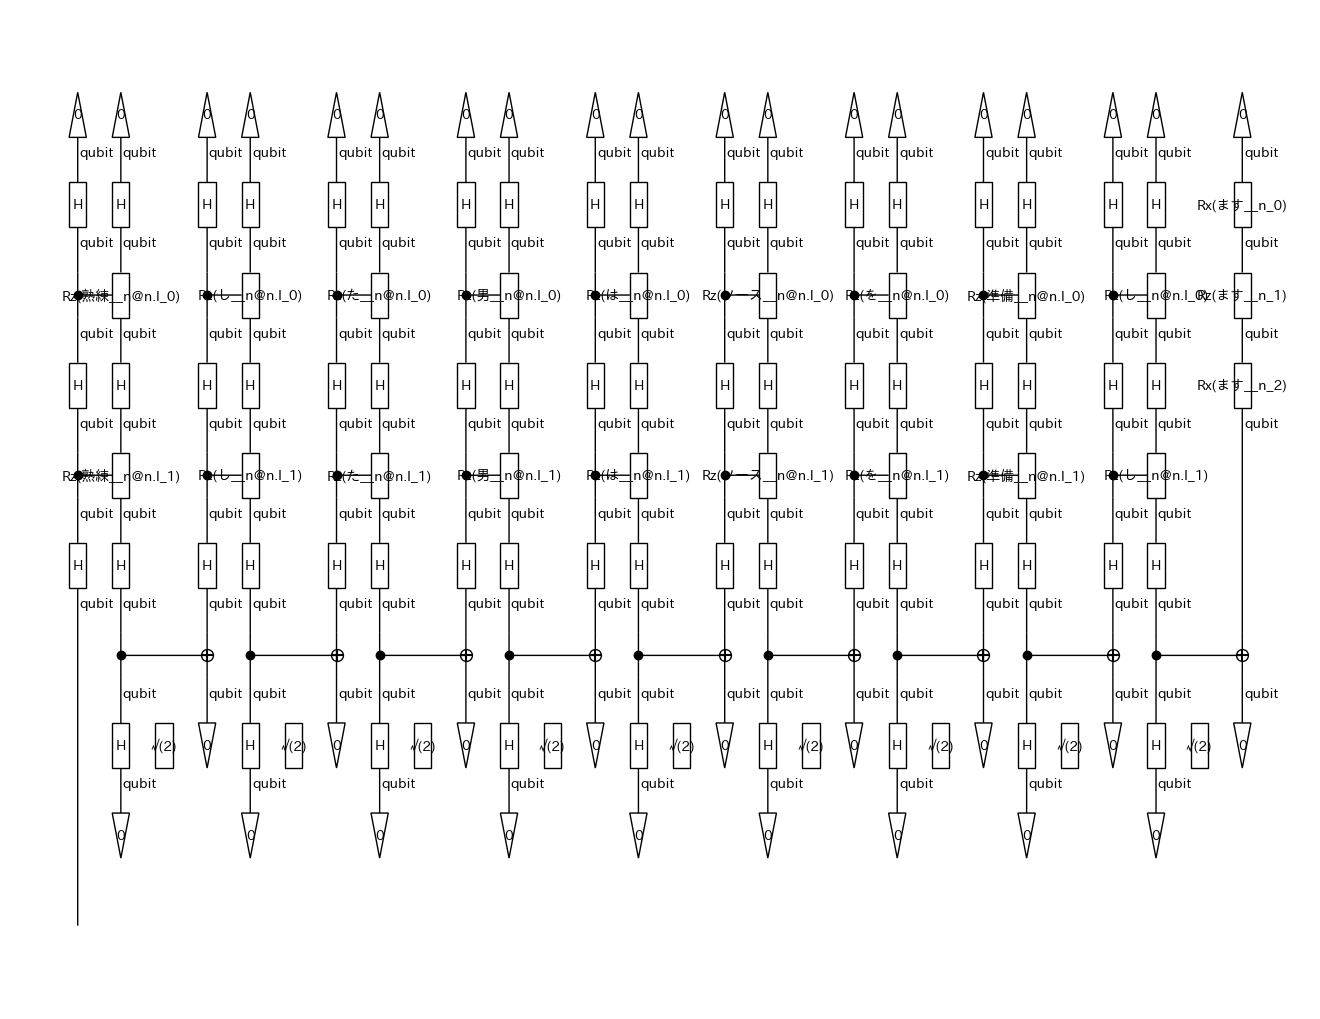

{し__n@n.l_0,
 し__n@n.l_1,
 た__n@n.l_0,
 た__n@n.l_1,
 は__n@n.l_0,
 は__n@n.l_1,
 ます__n_0,
 ます__n_1,
 ます__n_2,
 を__n@n.l_0,
 を__n@n.l_1,
 ソース__n@n.l_0,
 ソース__n@n.l_1,
 準備__n@n.l_0,
 準備__n@n.l_1,
 熟練__n@n.l_0,
 熟練__n@n.l_1,
 男__n@n.l_0,
 男__n@n.l_1}

In [8]:
#0行目で確認
train_circuits[0].draw(figsize=(13,10))
train_circuits[0].free_symbols

In [9]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits +test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [10]:
from lambeq import BinaryCrossEntropyLoss

bce = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y:np.sum(np.round(y_hat) == y)/len(y)/2

In [11]:
BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 1000
SEED = 0

In [12]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0
)

In [13]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [14]:
trainer.fit(train_dataset, val_dataset, log_interval=50)

Epoch 50:    train/loss: 0.4069   valid/loss: 0.7731   train/time: 1m7s   valid/time: 25.05s   train/acc: 0.6571   valid/acc: 0.3333
Epoch 100:   train/loss: 0.5097   valid/loss: 0.6876   train/time: 15.66s   valid/time: 3.28s   train/acc: 0.7143   valid/acc: 0.3333
Epoch 150:   train/loss: 0.5066   valid/loss: 0.7137   train/time: 15.55s   valid/time: 3.31s   train/acc: 0.6714   valid/acc: 0.3667
Epoch 200:   train/loss: 0.6343   valid/loss: 0.6569   train/time: 18.08s   valid/time: 3.79s   train/acc: 0.6857   valid/acc: 0.4000
Epoch 250:   train/loss: 0.3651   valid/loss: 0.6638   train/time: 17.32s   valid/time: 3.73s   train/acc: 0.7571   valid/acc: 0.5333
Epoch 300:   train/loss: 0.3919   valid/loss: 0.6047   train/time: 17.56s   valid/time: 3.66s   train/acc: 0.7714   valid/acc: 0.5667
Epoch 350:   train/loss: 0.4829   valid/loss: 0.5101   train/time: 18.50s   valid/time: 4.01s   train/acc: 0.8286   valid/acc: 0.7667
Epoch 400:   train/loss: 0.2971   valid/loss: 0.4711   train/ti

Test accuracy: 0.8333333


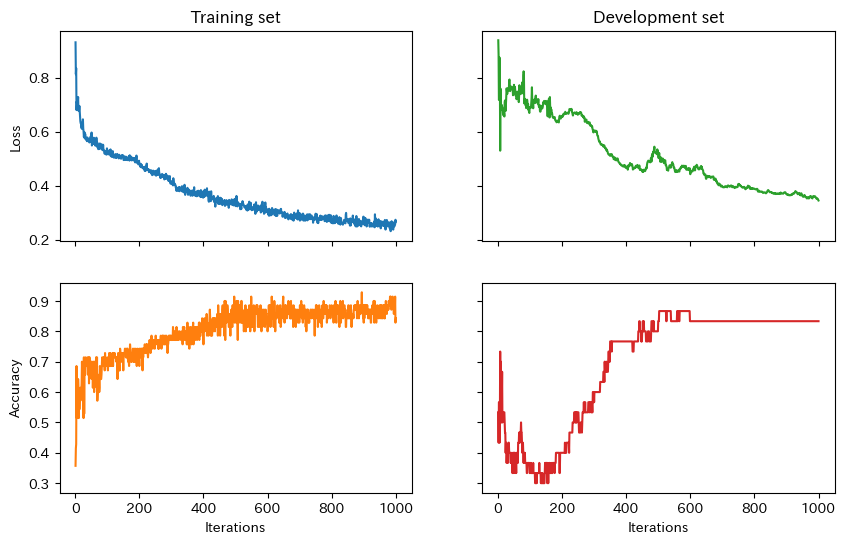

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)